This notebook serves as an example of how to load and manipulate the [QM9 dataset](https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904) using a `Dataset` object.

# Imports

In [1]:
import os
import numpy as np

from ase import Atoms

# Initialize the database

In [2]:
from colabfit.tools.database import MongoDatabase

client = MongoDatabase('colabfit_database', nprocs=6)

# Data loading

## Define the properties and reader functions

In [3]:
client.insert_property_definition({
    'property-id': 'qm9-property',
    'property-title': 'A, B, C, mu, alpha, homo, lumo, gap, r2, zpve, U0, U, H, G, Cv',
    'property-description': 'Geometries minimal in energy, corresponding harmonic frequencies, dipole moments, polarizabilities, along with energies, enthalpies, and free energies of atomization',
    'a':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant A'},
    'b':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant B'},
    'c':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Rotational constant C'},
    'mu':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Dipole moment'},
    'alpha': {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Isotropic polarizability'},
    'homo':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Energy of Highest occupied molecular orbital (HOMO)'},
    'lumo':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Energy of Lowest occupied molecular orbital (LUMO)'},
    'gap':   {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Gap, difference between LUMO and HOMO'},
    'r2':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Electronic spatial extent'},
    'zpve':  {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Zero point vibrational energy'},
    'u0':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Internal energy at 0 K'},
    'u':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Internal energy at 298.15 K'},
    'h':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Enthalpy at 298.15 K'},
    'g':     {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Free energy at 298.15 K'},
    'cv':    {'type': 'float', 'has-unit': True, 'extent': [], 'required': True, 'description': 'Heat capacity at 298.15 K'},
    'smiles-relaxed':    {'type': 'string', 'has-unit': False, 'extent': [], 'required': True, 'description': 'SMILES for relaxed geometry'},
    'inchi-relaxed':     {'type': 'string', 'has-unit': False, 'extent': [], 'required': True, 'description': 'InChI for relaxed geometry'},
})

/home/josh/colabfit/colabfit/tools/database.py:906: UserWarning: Property definition with name 'qm9-property' already exists. Using existing definition.
  warnings.warn(
/home/josh/colabfit/colabfit/tools/database.py:920: UserWarning: Invalid KIM property-id; Temporarily renaming to tag:@,0000-00-00:property/qm9-property. See https://openkim.org/doc/schema/properties-framework/ for more details.
  warnings.warn(


## Defining a `property_map`

In [4]:
property_map = {
    'qm9-property': {
        # Property Definition field: {'field': ASE field, 'units': ASE-readable units}
        'a':     {'field': 'A',     'units': 'GHz'},
        'b':     {'field': 'B',     'units': 'GHz'},
        'c':     {'field': 'C',     'units': 'GHz'},
        'mu':    {'field': 'mu',    'units': 'Debye'},
        'alpha': {'field': 'alpha', 'units': 'Bohr*Bohr*Bohr'},
        'homo':  {'field': 'homo',  'units': 'Hartree'},
        'lumo':  {'field': 'lumo',  'units': 'Hartree'},
        'gap':   {'field': 'gap',   'units': 'Hartree'},
        'r2':    {'field': 'r2',    'units': 'Bohr*Bohr'},
        'zpve':  {'field': 'zpve',  'units': 'Hartree'},
        'u0':    {'field': 'U0',    'units': 'Hartree'},
        'u':     {'field': 'U',     'units': 'Hartree'},
        'h':     {'field': 'H',     'units': 'Hartree'},
        'g':     {'field': 'G',     'units': 'Hartree'},
        'cv':    {'field': 'Cv',    'units': 'cal/mol/K'},
        'smiles-relaxed': {'field': 'SMILES_relaxed', 'units': None},
        'inchi-relaxed': {'field': 'SMILES_relaxed',  'units': None},
    }
}

In [5]:
def reader(file_path):
    # A function for returning a list of ASE a
    
    properties_order = [
        'tag', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'
    ]
        
    with open(file_path, 'r') as f:
        lines = [_.strip() for _ in f.readlines()]
        
        na = int(lines[0])
        properties = lines[1].split()
        
        symbols = []
        positions = []
        partial_charges = []
        
        for line in lines[2:2+na]:
            split = line.split()
            split = [_.replace('*^', 'e') for _ in split]  # Python-readable scientific notation
            
            # Line order: symbol, x, y, z, charge
            symbols.append(split[0])
            positions.append(split[1:4])
            partial_charges.append(split[-1])
            
        positions = np.array(positions)
        partial_charges = np.array(partial_charges, dtype=float)
                
        atoms = Atoms(symbols=symbols, positions=positions)
        
        atoms.info['mulliken_partial_charges'] = partial_charges
        
        name = os.path.splitext(os.path.split(file_path)[-1])[0]

        atoms.info['name'] = name
        
        for pname, val in zip(properties_order[2:], properties[2:]):
            atoms.info[pname] = float(val)
            
        frequencies = np.array(lines[-3].split(), dtype=float)
        atoms.info['frequencies'] = frequencies
                
        smiles = lines[-2].split()
        inchi  = lines[-1].split()
        
        atoms.info['SMILES']    = smiles[0]
        atoms.info['SMILES_relaxed'] = smiles[1]
        atoms.info['InChI']     = inchi[0]
        atoms.info['InChI_relaxed']  = inchi[1]
        
        yield atoms

## Load and insert the data

In [6]:
from colabfit.tools.database import load_data

images = list(load_data(
    file_path='/colabfit/data/quantum-machine/qm9',
    file_format='folder',
    name_field='name',  # key in Configuration.info to use as the Configuration name
    elements=['H', 'C', 'N', 'O', 'F'],    # order matters for CFG files, but not others
    default_name='qm9',  # default name with `name_field` not found
    reader=reader,
    glob_string='*.xyz',
    # verbose=True
))

In [7]:
from colabfit.tools.property_settings import PropertySettings

pso = PropertySettings(
    method='DFT/B3LYP/6-31G(2df,p)',
    description='QM9 property settings calculation',
    files=None,
    labels=['DFT', 'B3LYP', '6-31G(2df,p)'],
)

ids = list(client.insert_data(
    images,
    property_map=property_map,
    property_settings={'qm9-property': pso},
    generator=False,
    verbose=True
))

Preparing to add configurations to Database: 100%|████████████████████████████████████████████████| 23330/23330 [00:35<00:00, 654.15it/s]


In [8]:
len(ids)

139980

# Defining `ConfigurationSet`s

In [9]:
co_ids1 = client.get_data('configurations', fields='_id', query={'names': {'$regex': 'dsC7O2H10nsd'}}, ravel=True).tolist()
co_ids2 = client.get_data('configurations', fields='_id', query={'names': {'$regex': 'dsgdb9nsd'}}, ravel=True).tolist()

print('Configuration set 1', '(dsC7O2H10nsd):'.rjust(15), f'{len(co_ids1)}'.rjust(7))
print('Configuration set 2', '(dsgdb9nsd):'.rjust(15), f'{len(co_ids2)}'.rjust(7))

Configuration set 1 (dsC7O2H10nsd):    6095
Configuration set 2    (dsgdb9nsd):  133885


In [10]:
cs_id1 = client.insert_configuration_set(
    co_ids1,
    description='Isomers of C7O2H10',
    verbose=True
)
cs_id1

Aggregating configuration info: 100%|█████████████████████████████████████████████████████████████| 6095/6095 [00:00<00:00, 12442.17it/s]


'12696217217751242207'

In [11]:
cs_id2 = client.insert_configuration_set(
    co_ids2,
    description='The subset of all 133,885 species with up to '\
    'nine heavy atoms (CONF) out of the GDB-17 chemical universe '\
    'of 166 billion organic molecules',
    verbose=True
)
cs_id2

Aggregating configuration info: 100%|██████████████████████████████████████████████████████████| 133885/133885 [00:17<00:00, 7703.85it/s]


'3564515628319764272'

In [12]:
cs1 = client.get_configuration_set(cs_id1)['configuration_set']

print(cs1.description)

for k,v in cs1.aggregated_info.items():
    print(k, v)

Isomers of C7O2H10
nconfigurations 6095
nsites 115805
nelements 3
chemical_systems ['CHO']
elements ['C', 'H', 'O']
individual_elements_ratios {'C': [0.37], 'H': [0.53], 'O': [0.11]}
total_elements_ratios {'C': 0.3684210526315789, 'H': 0.5263157894736842, 'O': 0.10526315789473684}
labels []
labels_counts []
chemical_formula_reduced ['C7H10O2']
chemical_formula_anonymous ['A10B7C2']
chemical_formula_hill ['C7H10O2']
nperiodic_dimensions [0]
dimension_types [[0, 0, 0]]


In [13]:
cs2 = client.get_configuration_set(cs_id2)['configuration_set']

print(cs2.description)

for k,v in cs2.aggregated_info.items():
    print(k, v)

The subset of all 133,885 species with up to nine heavy atoms (CONF) out of the GDB-17 chemical universe of 166 billion organic molecules
nconfigurations 133885
nsites 2407753
nelements 5
chemical_systems ['CHN', 'HO', 'CFH', 'NO', 'CNO', 'CFHO', 'CFN', 'CN', 'CF', 'CH', 'CHO', 'CHNO', 'CFNO', 'HN', 'CFHNO', 'CFHN']
elements ['C', 'H', 'N', 'O', 'F']
individual_elements_ratios {'C': [0.35, 0.38, 0.29, 0.31, 0.46, 0.41, 0.42, 0.25, 0.39, 0.32, 0.5, 0.67, 0.75, 0.26, 0.43, 0.18, 0.6, 0.11, 0.27, 0.69, 0.44, 0.19, 0.36, 0.28, 0.53, 0.7, 0.78, 0.45, 0.2, 0.37, 0.62, 0.12, 0.21, 0.23, 0.54, 0.22, 0.17, 0.15, 0.71, 0.09, 0.1, 0.3, 0.47, 0.55, 0.8, 0.14, 0.64, 0.56, 0.4, 0.57, 0.24, 0.58, 0.33], 'H': [0.53, 0.47, 0.44, 0.57, 0.36, 0.31, 0.25, 0.5, 0.64, 0.33, 0.59, 0.67, 0.42, 0.75, 0.43, 0.18, 0.6, 0.11, 0.27, 0.69, 0.61, 0.7, 0.2, 0.45, 0.62, 0.12, 0.29, 0.1, 0.22, 0.54, 0.17, 0.71, 0.46, 0.38, 0.63, 0.3, 0.55, 0.8, 0.14, 0.56, 0.73, 0.4, 0.65, 0.58], 'N': [0.06, 0.12, 0.42, 0.19, 0.13, 0.3

# Defining `Dataset`s

In [14]:
all_co_ids, all_pr_ids = list(zip(*ids))
len(all_pr_ids)

139980

In [15]:
ds_id = client.insert_dataset(
    cs_ids=[cs_id1, cs_id2],
    pr_ids=all_pr_ids,
    name='QM9',
    authors=['Raghunathan Ramakrishnan', 'Pavlo Dral', 'Matthias Rupp', 'O. Anatole von Lilienfeld'],
    links=[
        'https://www.nature.com/articles/sdata201422',
        'https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904'
    ],
    description="The QM9 dataset, split into the GDB-9 molecules and the C7O2H10 isomers",
    resync=True,
    verbose=True,
)
ds_id

Updating PR->DS relationships: 100%|█████████████████████████████████████████████████████████| 139980/139980 [00:00<00:00, 159835.73it/s]


'9615499379302979156'

In [16]:
ds_id = '9615499379302979156'
dataset = client.get_dataset(ds_id, resync=True, verbose=True)['dataset']

for k,v in dataset.aggregated_info.items():
    print(k,v)

Aggregating property info: 100%|██████████████████████████████████████████████████████████████| 139980/139980 [00:09<00:00, 14936.86it/s]

nconfigurations 139980
nsites 2523558
nelements 5
chemical_systems ['CHN', 'HO', 'CFH', 'NO', 'CNO', 'CFHO', 'CFN', 'CN', 'CF', 'CH', 'CHO', 'CHNO', 'CFNO', 'HN', 'CFHNO', 'CFHN']
elements ['C', 'H', 'N', 'O', 'F']
individual_elements_ratios {'C': [0.35, 0.38, 0.29, 0.31, 0.46, 0.41, 0.42, 0.25, 0.39, 0.32, 0.5, 0.67, 0.75, 0.26, 0.43, 0.18, 0.6, 0.11, 0.27, 0.69, 0.44, 0.19, 0.36, 0.28, 0.53, 0.7, 0.78, 0.45, 0.2, 0.37, 0.62, 0.12, 0.21, 0.23, 0.54, 0.22, 0.17, 0.15, 0.71, 0.09, 0.1, 0.3, 0.47, 0.55, 0.8, 0.14, 0.64, 0.56, 0.4, 0.57, 0.24, 0.58, 0.33], 'H': [0.53, 0.47, 0.44, 0.57, 0.36, 0.31, 0.25, 0.5, 0.64, 0.33, 0.59, 0.67, 0.42, 0.75, 0.43, 0.18, 0.6, 0.11, 0.27, 0.69, 0.61, 0.7, 0.2, 0.45, 0.62, 0.12, 0.29, 0.1, 0.22, 0.54, 0.17, 0.71, 0.46, 0.38, 0.63, 0.3, 0.55, 0.8, 0.14, 0.56, 0.73, 0.4, 0.65, 0.58], 'N': [0.06, 0.12, 0.42, 0.19, 0.13, 0.36, 0.07, 0.24, 0.2, 0.31, 0.25, 0.5, 0.67, 0.75, 0.18, 0.43, 0.35, 0.6, 0.05, 0.11, 0.27, 0.44, 0.04, 0.28, 0.45, 0.62, 0.29, 0.21, 0.17, 

# Exploration

In [17]:
client.get_statistics(
    ['qm9-property.a', 'qm9-property.b', 'qm9-property.c'],
    ids=dataset.property_ids,
    verbose=True
)

Getting data: 139980it [00:03, 41978.52it/s]
Getting data: 139980it [00:01, 73389.95it/s] 
Getting data: 139980it [00:02, 58456.93it/s] 


{'qm9-property.a': {'average': 9.51711730523646,
  'std': 1769.62737731538,
  'min': 0.0,
  'max': 619867.68314,
  'average_abs': 9.51711730523646},
 'qm9-property.b': {'average': 1.4058212172188884,
  'std': 1.5506854782530948,
  'min': 0.33712,
  'max': 437.90386,
  'average_abs': 1.4058212172188884},
 'qm9-property.c': {'average': 1.1257341079297043,
  'std': 1.0729571269741767,
  'min': 0.33118,
  'max': 282.94545,
  'average_abs': 1.1257341079297043}}

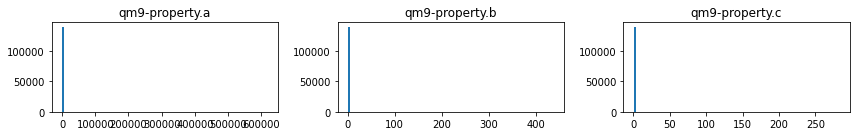

In [19]:
fig = client.plot_histograms(
    ['qm9-property.a', 'qm9-property.b', 'qm9-property.c',],
    ids=dataset.property_ids
)

In [21]:
client.dataset_to_markdown(
    ds_id=ds_id,
    base_folder='/colabfit/markdown/'+dataset.name,
    html_file_name='README.md',
    data_format='mongo',
    data_file_name=None,
    histogram_fields=[
        'qm9-property.a',
        'qm9-property.b',
        'qm9-property.c',
        'qm9-property.mu',
        'qm9-property.alpha',
        'qm9-property.homo',
        'qm9-property.lumo',
        'qm9-property.gap',
        'qm9-property.r2',
        'qm9-property.zpve',
        'qm9-property.u0',
        'qm9-property.u',
        'qm9-property.h',
        'qm9-property.g',
        'qm9-property.cv',
#         'qm9-property.smiles-relaxed',
#         'qm9-property.inchi-relaxed'
    ],
    yscale='log'
)

In [22]:
clean_config_sets, clean_property_ids = client.filter_on_properties(
    ds_id=ds_id,
    filter_fxn=lambda x: (x['qm9-property']['a']['source-value'] < 20) and x['qm9-property']['b']['source-value'] < 10,
    fields=['qm9-property.a.source-value', 'qm9-property.b.source-value'],
    verbose=True
)

Filtering on properties: 139980it [00:03, 43645.37it/s]
Aggregating configuration info: 100%|██████████████████████████████████████████████████████████| 133779/133779 [00:17<00:00, 7548.38it/s]


In [23]:
new_cs_ids = []
for cs in clean_config_sets:
    new_cs_ids.append(client.insert_configuration_set(cs.configuration_ids, cs.description, verbose=True))
    
print(new_cs_ids)

Aggregating configuration info: 100%|██████████████████████████████████████████████████████████| 133779/133779 [00:17<00:00, 7547.01it/s]


['12696217217751242207', '6492462216378875708']


In [24]:
ds_id_clean = client.insert_dataset(
    cs_ids=new_cs_ids,
    pr_ids=clean_property_ids,
    name='QM9_filtered',
    authors=dataset.authors,
    links=[
        'https://www.nature.com/articles/sdata201422',
        'https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904'
    ],
    description="The QM9 dataset, filtered by removing values with a>=20 or b>=10",
    resync=True,
    verbose=True,
)
ds_id_clean

Updating PR->DS relationships: 100%|█████████████████████████████████████████████████████████| 139874/139874 [00:01<00:00, 122753.09it/s]


'3071118515767946833'

In [25]:
ds_id_clean = '3071118515767946833'

clean_ds = client.get_dataset(ds_id_clean)['dataset']
len(clean_ds.property_ids)

139874

Getting data: 139874it [00:02, 58771.45it/s] 
Getting data: 139874it [00:01, 74584.67it/s] 
Getting data: 139874it [00:02, 61277.20it/s] 


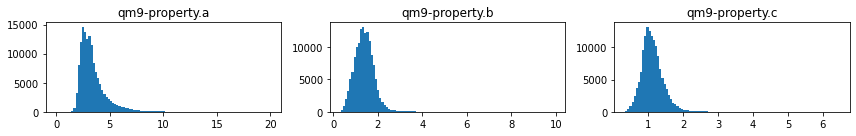

In [27]:
fig = client.plot_histograms(
    ['qm9-property.a', 'qm9-property.b', 'qm9-property.c'],
    ids=clean_ds.property_ids,
    verbose=True
)

In [29]:
client.dataset_to_markdown(
    ds_id=ds_id_clean,
    base_folder='/colabfit/markdown/'+clean_ds.name,
    html_file_name='README.md',
    data_format='mongo',
    data_file_name=None,
    histogram_fields=[
        'qm9-property.a',
        'qm9-property.b',
        'qm9-property.c',
        'qm9-property.mu',
        'qm9-property.alpha',
        'qm9-property.homo',
        'qm9-property.lumo',
        'qm9-property.gap',
        'qm9-property.r2',
        'qm9-property.zpve',
        'qm9-property.u0',
        'qm9-property.u',
        'qm9-property.h',
        'qm9-property.g',
        'qm9-property.cv',
#         'qm9-property.smiles-relaxed',
#         'qm9-property.inchi-relaxed'
    ],
    yscale='log'
)